In [1]:
import sys
import pickle
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

In [3]:
with open('spike_dict_fixshortvid2_didi.pkl', 'rb') as file: 
          spike_dict = pickle.load(file)

In [4]:
# Function to get all the spike information for a single neuron
def prep_data(neuron):
    single_neuron = [[] for x in range(len(neuron))]
    
    for i in range(len(neuron)):
    # print(i) 
        for j in neuron[i][0]:
            if j[0] is not None:
                single_neuron[i].append(j[0])
                
    return single_neuron

# Function to concatenate spikes for all video clips, split into two groups and correlate 
def r_2_long_train(spike_object):
    # Parameters
    bin_width = 0.05  # bin width in seconds
    max_time = 0.300   # maximum time to consider

    # Create bins
    bins = np.arange(-.05, max_time + bin_width, bin_width)
    
    r_2s = []

    # set this range n to find get an average r^2 value between groups
    for j in range(100):
        all_clips_split1 = []
        all_clips_split2 = []
        for i in range(len(spike_object)):
            # Bin the spike times for each trial
            binned_spike_counts = []
            if len(spike_object[i]) > 0: 
                for spikes in spike_object[i]:
                    counts, _ = np.histogram(spikes, bins=bins)
                    binned_spike_counts.append(counts)

                # Convert binned spike counts to numpy array for easier handling
                binned_spike_counts = np.array(binned_spike_counts)
                
                # Permute and split the repeats to get two avg spike counts per clip
                r = np.random.permutation(binned_spike_counts)
                
                mu_1 = np.mean(r[:len(spike_object[i])//2], axis=0)
                all_clips_split1.append(mu_1)

                mu_2 = np.mean(r[len(spike_object[i])//2:], axis=0)
                all_clips_split2.append(mu_2)

        splits = pd.DataFrame({'split1': np.concatenate(all_clips_split1), 'split2': np.concatenate(all_clips_split2)})
        # get r^2 between groups
        r_2 = splits.corr().iloc[0,1]**2
        # r_2 = (np.corrcoef(np.concatenate(all_clips_split1), np.concatenate(all_clips_split2))**2)[0][1]
        r_2s.append(r_2)
            
    return r_2s

def get_shape(obj):
    shape = [len(obj[i]) for i in range(len(obj))]
    return shape

# Helper function to flatten the nested list while preserving the innermost sub-arrays
def flatten_list(lst):
    flattened = []
    for sub_array in lst:
        flattened.extend(sub_array)
    return flattened

def reshape_based_on_grouping(flattened, grouping):
    reshaped = []
    index = 0
    for group_size in grouping:
        reshaped.append(flattened[index:index + group_size])
        index += group_size
    return reshaped

# Function to flip arrays of spikes to create null distribution 
def maybe_flip_array(arr):
    arr = np.asarray(arr)  # Ensure input is a numpy array
    if arr.ndim == 0 or arr.size == 0:
        return arr  # Return the array as is if it is empty or 0-dimensional
    if np.random.rand() > 0.5:
        return arr[::-1]  # Reverse the array
    else:
        return arr

# Function to iterate through a list of arrays and apply maybe_flip_array to each
def process_list_of_arrays(arr_list):
    processed_arrays = []
    for arr in arr_list:
        flipped_array = maybe_flip_array(arr)
        processed_arrays.append(flipped_array)
        # Debug prints to check the state of arrays
        print(f"Original array: {arr}")
        print(f"Processed array: {flipped_array}")
    return processed_arrays

In [9]:
# initialize empty arrays
d_prime_all_neurons_2 = []
avg_r2_2 = []
avg_null_r2_2 = []

In [11]:
# set the seed for reproducibility
np.random.seed(0)

# for each neuron, do signal correlation for true distribution and null distribution
for i in range(len(spike_dict['spikes'])):
    single_neuron = prep_data(spike_dict['spikes'][i][0])
    r2s_true = r_2_long_train(single_neuron)
    
    shape = get_shape(single_neuron)
    flat = flatten_list(single_neuron)
    
    np.random.shuffle(flat)

    flat = [maybe_flip_array(x) for x in flat]
    
    reshape_shuffled = reshape_based_on_grouping(flat, shape)
    
    r2s_null = r_2_long_train(reshape_shuffled)
             
    r2_avg, r2_std = np.nanmean(r2s_true), np.nanstd(r2s_true)
    r2n_avg, r2n_std = np.nanmean(r2s_null), np.nanstd(r2s_null)
    
    d_prime = (r2_avg-r2n_avg)/(.5*(r2_std+r2n_std))
    
    avg_r2_2.append(r2_avg)
    avg_null_r2_2.append(r2n_avg)
    d_prime_all_neurons_2.append(d_prime)
    
    # print out results, or can comment this line out
    print(f'averaged over all clips Neuron {i}, True R2: {r2_avg}, Null R2: {r2n_avg}, D\': {d_prime}')
    

averaged over all clips Neuron 0, True R2: 0.00011784319511403133, Null R2: 0.00021036719140629624, D': -0.439786718039914
averaged over all clips Neuron 1, True R2: 0.00015633207935741815, Null R2: 0.00029941020941569643, D': -0.4858549393126499
averaged over all clips Neuron 2, True R2: 0.0001923256647884464, Null R2: 0.0007605383152456863, D': -1.3259475725346148
averaged over all clips Neuron 3, True R2: 0.0007777227320619469, Null R2: 0.00058748335108497, D': 0.3153749290873147
averaged over all clips Neuron 4, True R2: 0.0001401808220075471, Null R2: 0.00043737819870305644, D': -0.9739200908730533
averaged over all clips Neuron 5, True R2: 0.0005814729631027382, Null R2: 0.0002897780736370454, D': 0.732501207043528
averaged over all clips Neuron 6, True R2: 0.00032104067426841896, Null R2: 0.0004943685787031369, D': -0.4237583027655122
averaged over all clips Neuron 7, True R2: 0.00022031240730023107, Null R2: 0.00038886608914490985, D': -0.511159227095047
averaged over all clips

/Users/tigmoore/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tigmoore/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


averaged over all clips Neuron 15, True R2: 0.00014609789352206315, Null R2: 0.0002937486204148797, D': -0.5264022655201414
averaged over all clips Neuron 16, True R2: 0.0013347262447071689, Null R2: 0.0004033921261380951, D': 1.4963966940403644
averaged over all clips Neuron 17, True R2: 0.00016964411181101421, Null R2: 0.0004530723884073242, D': -0.936436471402317
averaged over all clips Neuron 18, True R2: 0.0003878205299217984, Null R2: 0.0001518924448791902, D': 0.8625070783500598
averaged over all clips Neuron 19, True R2: 0.0002911774590547127, Null R2: 0.00014362285361369662, D': 0.6398466555572334
averaged over all clips Neuron 20, True R2: 0.00018866697673108494, Null R2: 0.00013835769384831117, D': 0.2014981906881175
averaged over all clips Neuron 21, True R2: 0.00048710082014158433, Null R2: 0.0002078814733654401, D': 0.748818730346624
averaged over all clips Neuron 22, True R2: 0.0002502189027845175, Null R2: 0.00012456127991471752, D': 0.5299754791969803
averaged over all

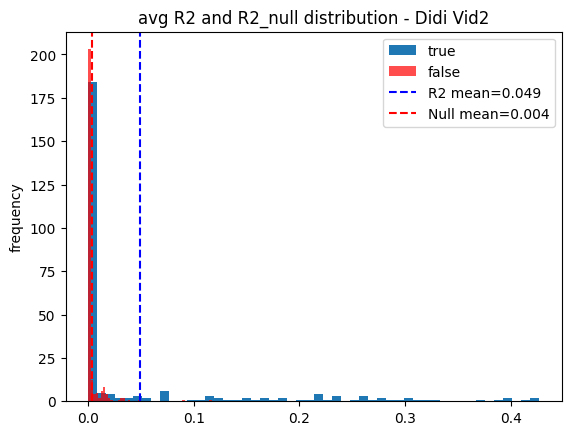

In [26]:
# plot histogram of null and true r^2 distributions
plt.hist(avg_r2_2, label = 'true', bins=50)
plt.hist(avg_null_r2_2, alpha = .7, label = 'false', bins=50, color='red')
plt.axvline(np.nanmean(avg_r2_2), color='blue', linestyle='--', label = f'R2 mean={np.nanmean(avg_r2_2):.3f}')
plt.axvline(np.nanmean(avg_null_r2_2), color='red', linestyle='--', label = f'Null mean={np.nanmean(avg_null_r2_2):.3f}')
# plt.xlim(0, .3)
plt.title('avg R2 and R2_null distribution - Didi Vid2')
plt.ylabel('frequency')
plt.legend()
plt.show()

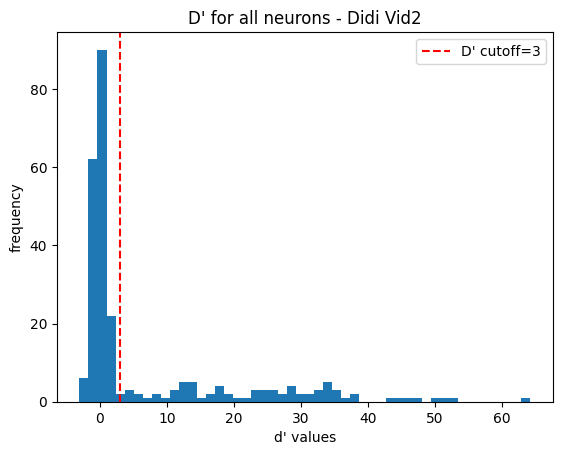

In [27]:
d_prime_cutoff = 3
# plot results for D' analysis 
# change the title for monkey name and recording session
plt.hist(d_prime_all_neurons_2, bins=50)
plt.title('D\' for all neurons - Didi Vid2')
plt.xlabel('d\' values')
plt.ylabel('frequency')
plt.axvline(d_prime_cutoff, color='red', linestyle='--', label = f'D\' cutoff={d_prime_cutoff}')
plt.legend()
plt.show()

In [15]:

# extract all neurons that have signal correlation above the chosen d' cutoff 
high_dprime_2 = [(i,j) for (i,j) in enumerate(d_prime_all_neurons_2) if j > d_prime_cutoff]

In [18]:
# double check R^2 values for high d' neurons
r2_highdprime = [avg_r2_2[index] for index, _ in high_dprime_2]

Text(0, 0.5, 'frequency')

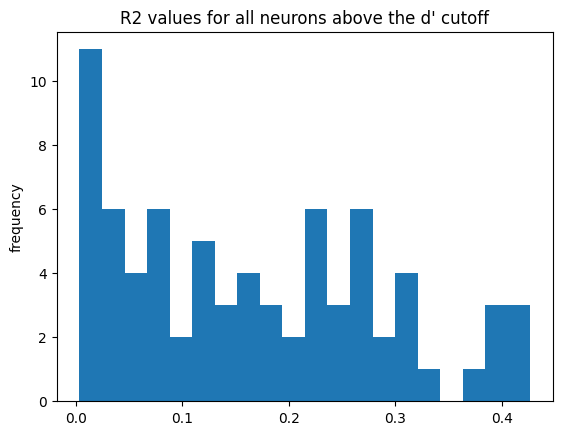

In [19]:
plt.hist(r2_highdprime, bins=20)
plt.title('R2 values for all neurons above the d\' cutoff')
plt.ylabel('frequency')

In [21]:
# create dict to save of neurons with strong signal to keep for further analysis
def neurons_2_keep(high_dprime):
    neurons_to_keep = {}
    for index, _ in high_dprime:
        single = prep_data(spike_dict['spikes'][index][0])
        neurons_to_keep[f'neuron_{index}'] = single
        
    return neurons_to_keep

In [22]:
good_neurons = neurons_2_keep(high_dprime_2)

In [23]:
# can see which neurons we keep according to their initial indices 
good_neurons.keys()

dict_keys(['neuron_67', 'neuron_85', 'neuron_98', 'neuron_128', 'neuron_131', 'neuron_132', 'neuron_135', 'neuron_143', 'neuron_146', 'neuron_154', 'neuron_156', 'neuron_157', 'neuron_159', 'neuron_160', 'neuron_162', 'neuron_164', 'neuron_165', 'neuron_166', 'neuron_167', 'neuron_169', 'neuron_170', 'neuron_172', 'neuron_174', 'neuron_175', 'neuron_177', 'neuron_178', 'neuron_179', 'neuron_181', 'neuron_182', 'neuron_183', 'neuron_185', 'neuron_186', 'neuron_187', 'neuron_188', 'neuron_189', 'neuron_192', 'neuron_193', 'neuron_194', 'neuron_197', 'neuron_198', 'neuron_199', 'neuron_201', 'neuron_202', 'neuron_203', 'neuron_204', 'neuron_205', 'neuron_207', 'neuron_208', 'neuron_209', 'neuron_210', 'neuron_212', 'neuron_214', 'neuron_215', 'neuron_217', 'neuron_218', 'neuron_220', 'neuron_223', 'neuron_224', 'neuron_225', 'neuron_226', 'neuron_227', 'neuron_229', 'neuron_230', 'neuron_231', 'neuron_234', 'neuron_236', 'neuron_238', 'neuron_243', 'neuron_244', 'neuron_245', 'neuron_246'

In [24]:
# pickle out dictionary of responsive neurons
with open('responsive_neurons_vid2_didi.pkl', 'wb') as file: 
    pickle.dump(good_neurons, file)